In [21]:
import numpy as np
import matplotlib
from dask import dataframe as dd
from dask.distributed import Client, LocalCluster
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import pdb
import os

%matplotlib inline

In [22]:
!ls

df = dd.read_csv('time_split/preprocessed_by_time-*.csv', assume_missing=True)
df.head()

1015.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


day_of_week.py	     plot.png	requirements.txt  time_split.zip
day_of_week_agg.csv  poc.ipynb	time_split	  venv


,date_time,project_id,workflow_id,user_id,subjects_ids,country,timestamp,within_5,year,month,day,hour,minute,second,is_weekend,day_of_week
0,2022-02-19 23:18:39,1104.0,1935.0,2406720.0,39537309.0,Finland,1.645313e+09,True,2022.0,2.0,19.0,23.0,18.0,39.0,True,5.0
1,2022-02-19 23:18:39,15650.0,19298.0,2118075.0,72841292.0,Finland,1.645313e+09,True,2022.0,2.0,19.0,23.0,18.0,39.0,True,5.0
2,2022-02-19 23:18:40,11435.0,13693.0,847016.0,70060769.0,Finland,1.645313e+09,True,2022.0,2.0,19.0,23.0,18.0,40.0,True,5.0
3,2022-02-19 23:18:41,6490.0,19501.0,2417919.0,73058096.0,United States,1.645313e+09,True,2022.0,2.0,19.0,23.0,18.0,41.0,True,5.0
4,2022-02-19 23:18:41,11210.0,15553.0,1943326.0,70042169.0,United States,1.645313e+09,False,2022.0,2.0,19.0,23.0,18.0,41.0,True,5.0


In [23]:
# By day of week
day_of_week_agg = df.groupby(['country', 'day_of_week']).agg({'subjects_ids': 'count'}).compute().reset_index()
day_of_week_agg

,country,day_of_week,subjects_ids
0,Finland,5.0,2799988
1,United States,5.0,1153466
2,Singapore,5.0,464357
3,China,5.0,113170
4,Finland,6.0,2916260
5,United States,6.0,1092247
6,Singapore,6.0,516530
7,China,6.0,80169
8,Finland,3.0,3479708
9,United States,3.0,1622537


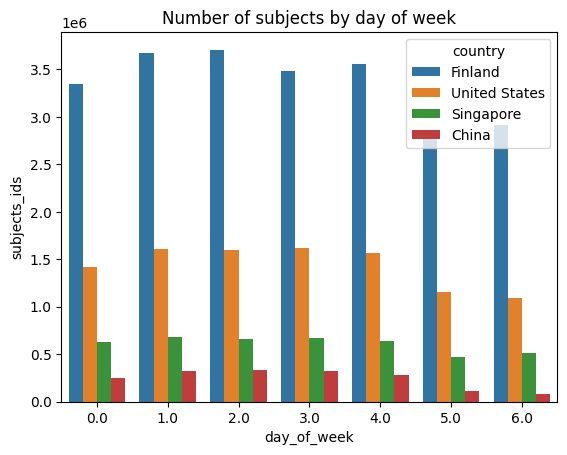

In [24]:
sns.barplot(x='day_of_week', y='subjects_ids', hue='country', data=day_of_week_agg).set_title('Number of subjects by day of week')

day_of_week_agg.to_csv('day_of_week_agg.csv', index=False)


In [68]:
by_month_activity = df.groupby(['country', 'year' ,'month']).agg({'subjects_ids': 'count'}).compute().reset_index()
by_month_activity


,country,year,month,subjects_ids
0,Finland,2022.0,2.0,3173442
1,United States,2022.0,2.0,1396062
2,Singapore,2022.0,2.0,402792
3,China,2022.0,2.0,157203
4,Singapore,2022.0,6.0,651155
5,United States,2022.0,6.0,831030
6,Finland,2022.0,6.0,2620866
7,China,2022.0,6.0,698467
8,United States,2021.0,12.0,1641957
9,Finland,2021.0,12.0,3436779


In [72]:
from re import A

def cumsum(df, country):
    df = df[df['country'] == country]
    df = df.sort_values(by=['year', 'month'])
    df = df[df['year'] != 1970]
    df['cumsum'] = df['subjects_ids'].cumsum()
    df['month'] = df['year'].astype(str) + '-' + df['month'].astype(str)
    return df

finland = cumsum(by_month_activity, 'Finland')
usa = cumsum(by_month_activity, 'United States')
singapore = cumsum(by_month_activity, 'Singapore')
china = cumsum(by_month_activity, 'China')


,country,year,month,subjects_ids,cumsum
34,China,2021.0,2021.0-11.0,140308,140308
10,China,2021.0,2021.0-12.0,174051,314359
17,China,2022.0,2022.0-1.0,172586,486945
3,China,2022.0,2022.0-2.0,157203,644148
37,China,2022.0,2022.0-3.0,3669,647817
24,China,2022.0,2022.0-5.0,58566,706383
7,China,2022.0,2022.0-6.0,698467,1404850
30,China,2022.0,2022.0-7.0,203449,1608299
22,China,2022.0,2022.0-8.0,86362,1694661


Text(0.5, 1.0, 'finland Monthly Engagement Over Time')

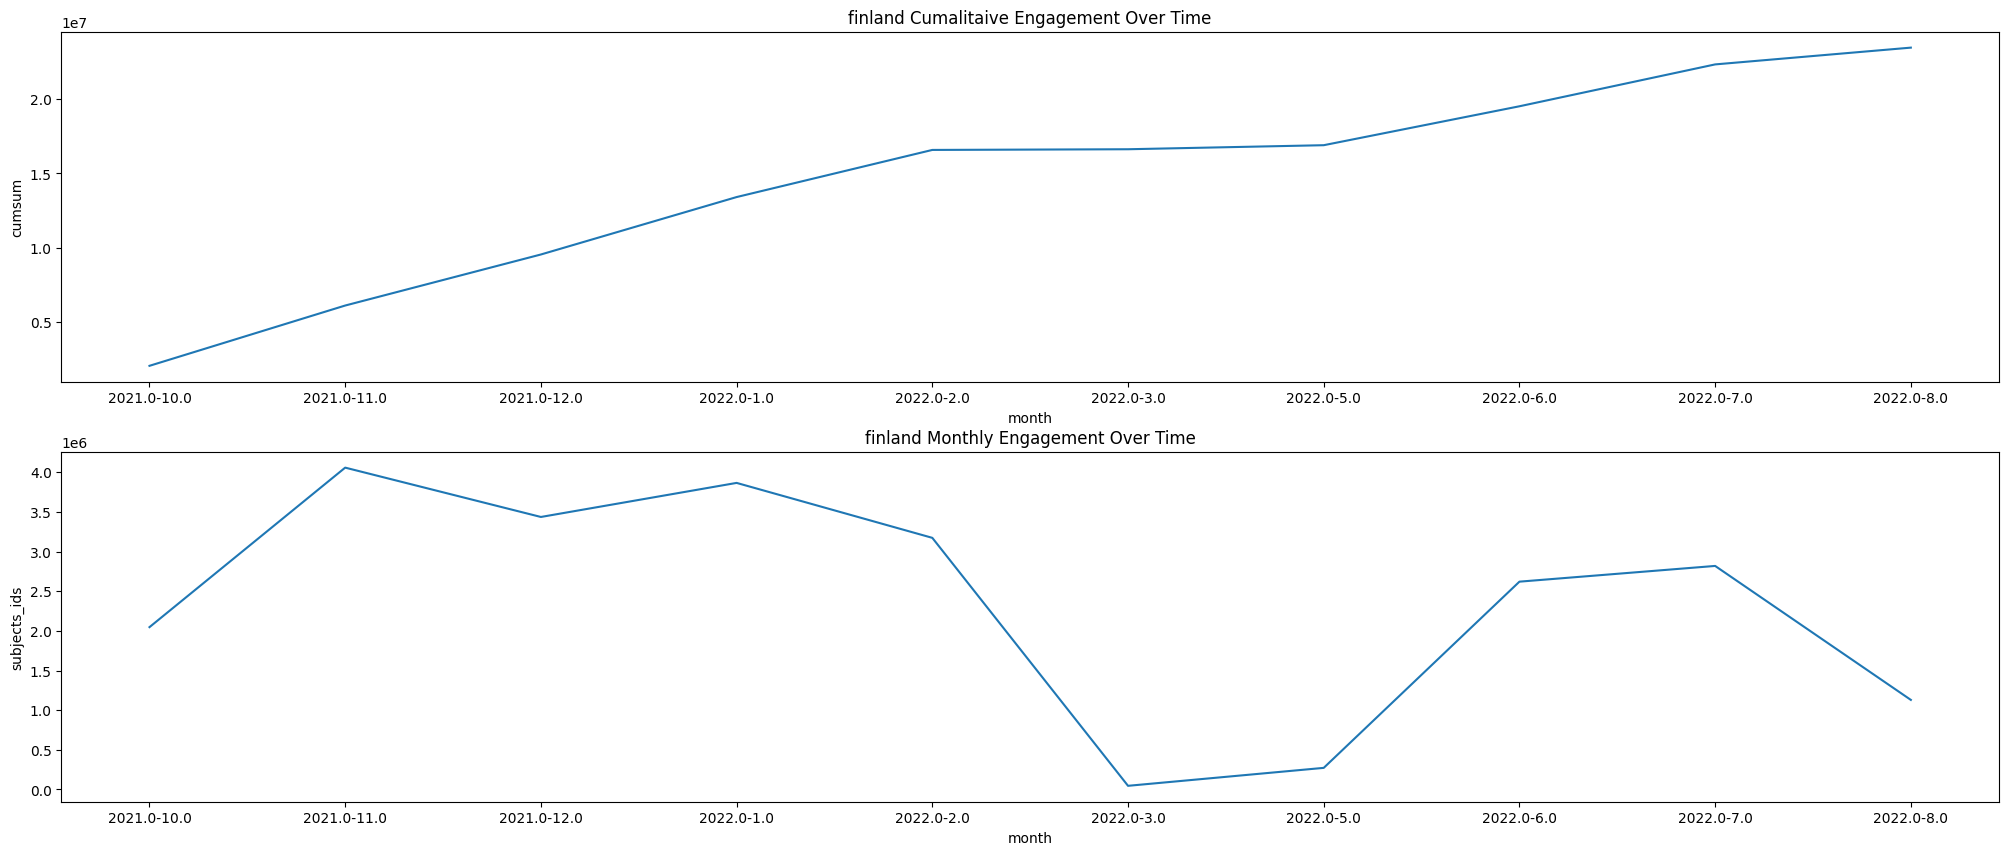

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(25, 10))
axs = axs.flatten()
sns.lineplot(x='month', y='cumsum', data=finland, ax=axs[0]).set_title('finland Cumalitaive Engagement Over Time')
sns.lineplot(x='month', y='subjects_ids', data=finland, ax=axs[1]).set_title('finland Monthly Engagement Over Time')

Text(0.5, 1.0, 'USA Monthly Engagement Over Time')

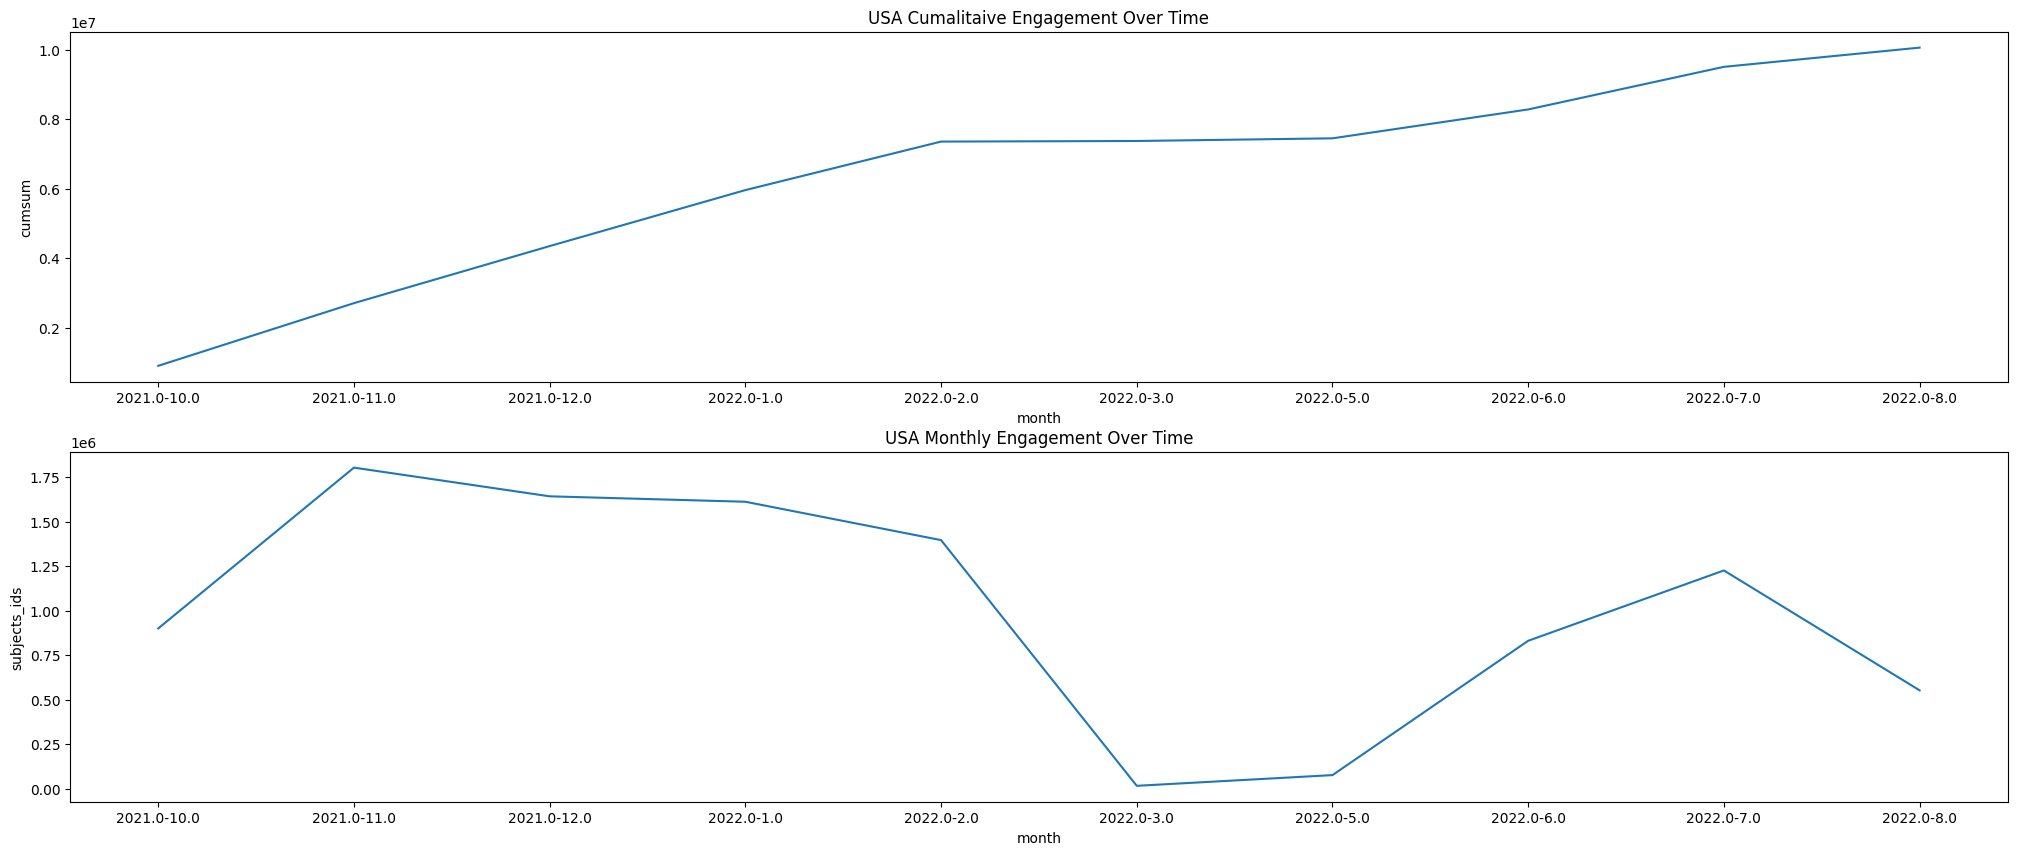

In [78]:
fig, axs = plt.subplots(2, 1, figsize=(25, 10))
axs = axs.flatten()
sns.lineplot(x='month', y='cumsum', data=usa, ax=axs[0]).set_title('USA Cumalitaive Engagement Over Time')
sns.lineplot(x='month', y='subjects_ids', data=usa, ax=axs[1]).set_title('USA Monthly Engagement Over Time')

Text(0.5, 1.0, 'china Monthly Engagement Over Time')

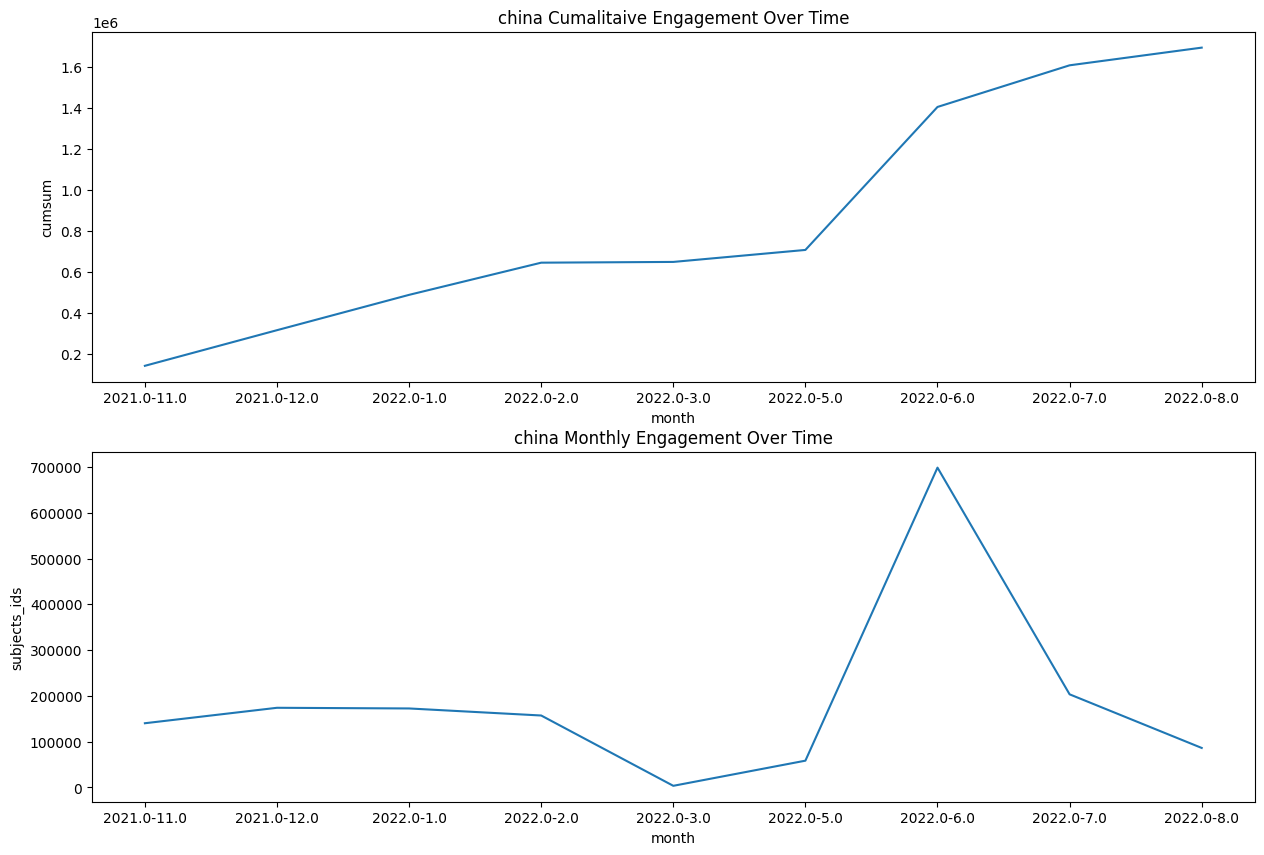

In [79]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs = axs.flatten()

sns.lineplot(x='month', y='cumsum', data=china, ax=axs[0]).set_title('china Cumalitaive Engagement Over Time')
sns.lineplot(x='month', y='subjects_ids', data=china, ax=axs[1]).set_title('china Monthly Engagement Over Time')

Text(0.5, 1.0, 'singapore Monthly Engagement Over Time')

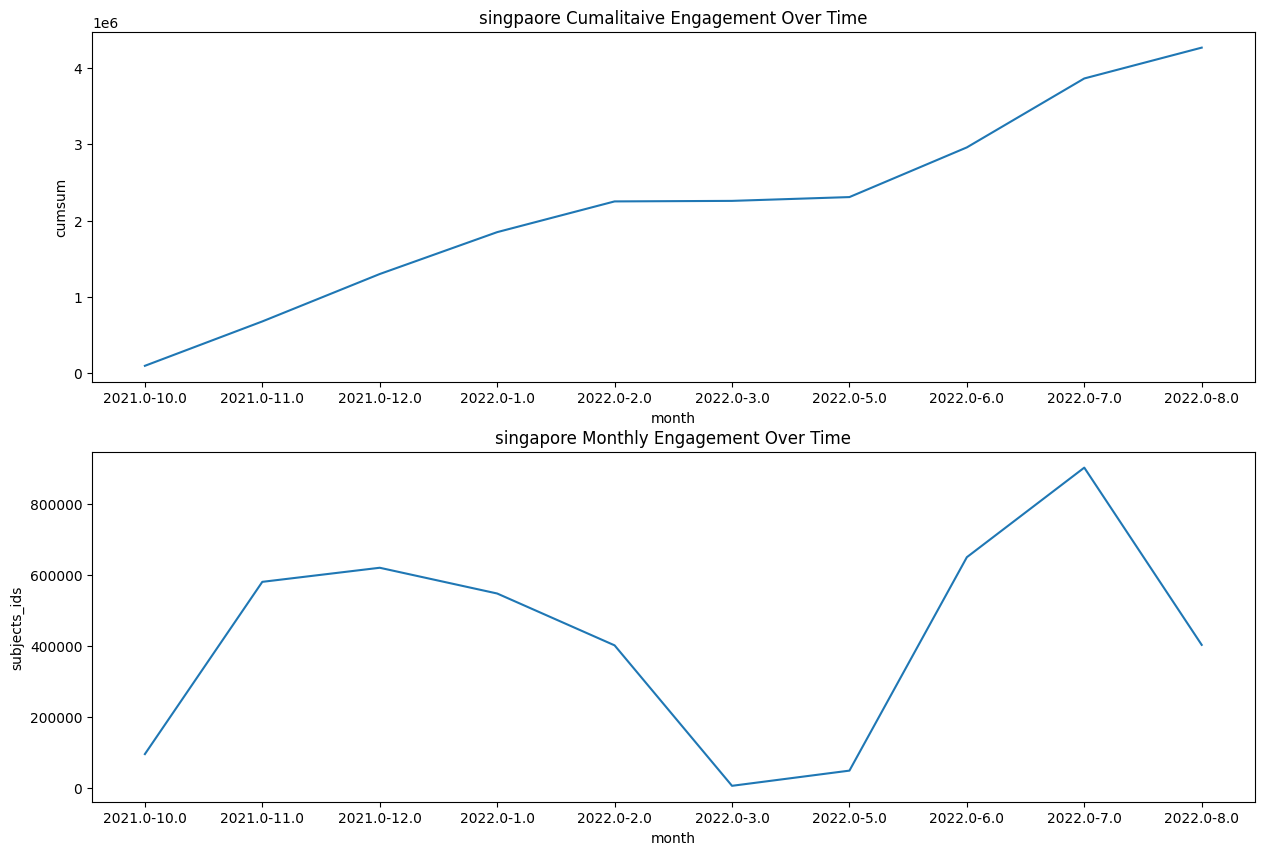

In [80]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs = axs.flatten()

sns.lineplot(x='month', y='cumsum', data=singapore, ax=axs[0]).set_title('singpaore Cumalitaive Engagement Over Time')
sns.lineplot(x='month', y='subjects_ids', data=singapore, ax=axs[1]).set_title('singapore Monthly Engagement Over Time')

In [81]:
by_month_activity.to_csv('by_month_activity.csv', index=False)